In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from sklearn.calibration import calibration_curve
from src.datasets.datasets import CPDDatasets
from src.ensembles.ensembles import EnsembleCPDModel
from src.metrics.evaluation_pipelines import (
    all_cusums_evaluation_pipeline,
    all_distances_evaluation_pipeline,
    evaluation_pipeline,
)
from src.metrics.metrics_utils import collect_model_predictions_on_set, compute_stds
from src.utils.temperature_scaling import ModelWithTemperature
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def calibrate_single_models(
    core_model, val_dataloader, preprocessor=None, verbose=True, device="cpu"
):
    core_model.to(device)
    if preprocessor:
        preprocessor.to(device)

    core_model.return_logits = True
    scaled_model = ModelWithTemperature(
        core_model, preprocessor=preprocessor, verbose=verbose
    )
    scaled_model.set_temperature(val_dataloader)
    core_model.return_logits = False
    return core_model


def calibrate_all_models_in_ensemble(
    ensemble_model, val_dataloader, preprocessor=None, verbose=True, device="cpu"
):
    for cpd_model in ensemble_model.models_list:
        _ = calibrate_single_models(
            cpd_model.model,
            val_dataloader,
            preprocessor=preprocessor,
            verbose=verbose,
            device=device,
        )


def uncalibrate_all_models_in_ensemble(ensemble_model):
    for cpd_model in ensemble_model.models_list:
        cpd_model.model.temperature = 1.0


def plot_calibration_curves(
    models_list,
    test_dataloader,
    model_type="seq2seq",
    device="cpu",
    title=None,
    verbose=False,
):
    x_ideal = np.linspace(0, 1, 20)

    plt.figure(figsize=(10, 8))
    plt.plot(x_ideal, x_ideal, linestyle="--", label="Ideally calibrated", c="black")

    for i, cpd_model in enumerate(models_list):
        test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
            cpd_model,
            test_dataloader,
            model_type=model_type,
            device=device,
            verbose=verbose,
        )

        test_out_flat = torch.vstack(test_out_bank).flatten()
        test_labels_flat = torch.vstack(test_labels_bank).flatten()

        prob_true, prob_pred = calibration_curve(
            test_labels_flat, test_out_flat, n_bins=10
        )

        plt.plot(
            prob_pred,
            prob_true,
            linestyle="--",
            marker="o",
            markersize=4,
            linewidth=1,
            label=f"Model num {i}",
        )
    if title:
        plt.title(title, fontsize=14)
    plt.xlabel("Predicted probability", fontsize=12)
    plt.ylabel("Fraction of positives", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

# Test

In [ ]:
# predictions = torch.rand(100)
# pred_std = torch.rand(100) / 4
# true_values = torch.randint(2, (100,))

# uct.viz.plot_calibration(predictions.numpy(), pred_std.numpy(), true_values.numpy());

# BCE HAR

In [19]:
model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [20]:
path_to_models_folder = "saved_models/bce/human_activity/full_sample"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [41]:
test_out_bank, test_uncertainties_bank, test_labels_bank = (
    collect_model_predictions_on_set(
        ens_bce, test_dataloader, model_type="ensemble", device="cpu"
    )
)

test_out_flat = torch.vstack(test_out_bank).flatten()
test_labels_flat = torch.vstack(test_labels_bank).flatten()
test_uncertainties_flat = torch.vstack(test_uncertainties_bank).flatten()

test_out_flat.shape, test_labels_flat.shape, test_uncertainties_flat.shape

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.80it/s]


(torch.Size([26740]), torch.Size([26740]), torch.Size([26740]))

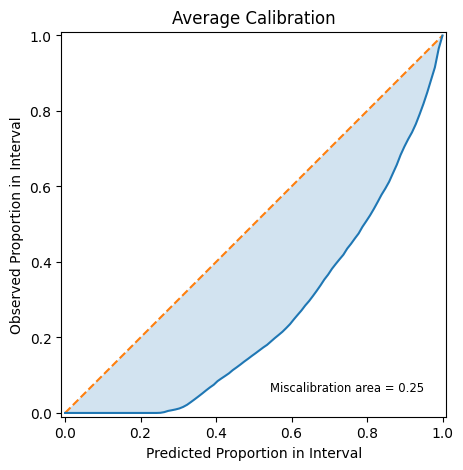

In [42]:
uct.viz.plot_calibration(
    test_out_flat.numpy(), test_uncertainties_flat.numpy(), test_labels_flat.numpy()
);

### Mean Ensemble

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:01<00:00, 17.86it/s]


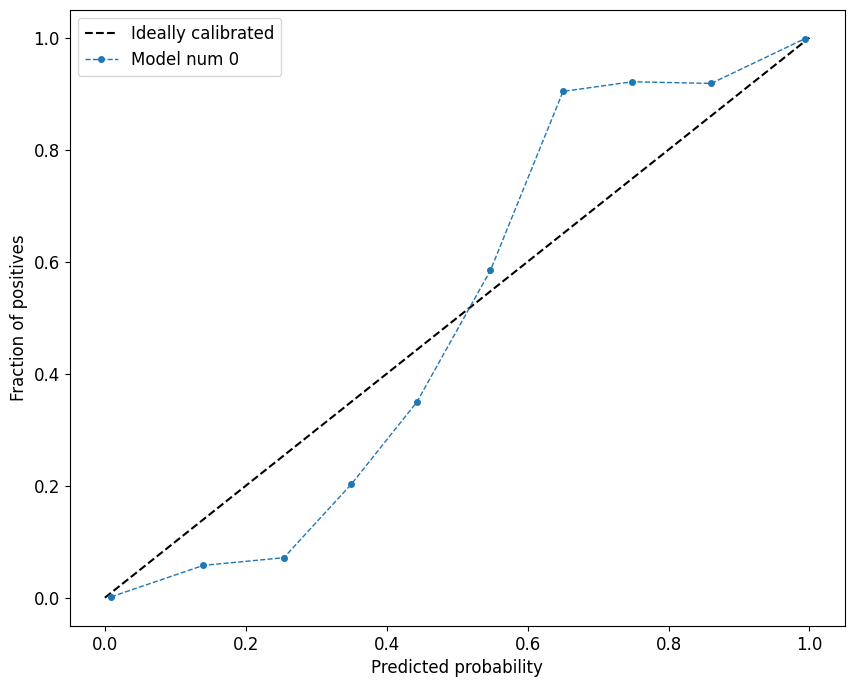

In [6]:
plot_calibration_curves([ens_bce], test_dataloader, model_type="ensemble")

### All single models

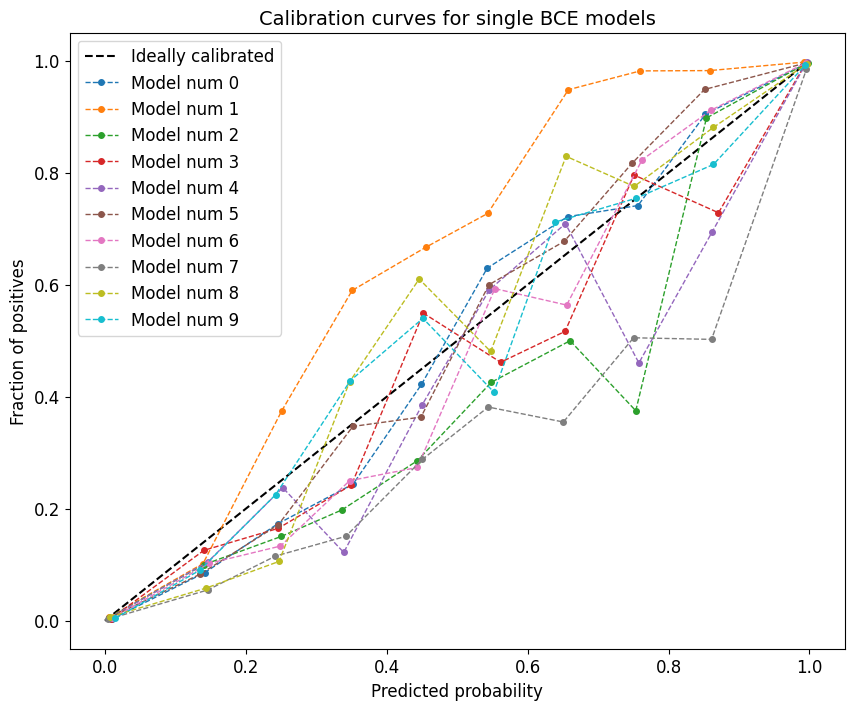

In [8]:
title = "Calibration curves for single BCE models"

plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title);

In [22]:
# wasserstein
threshold_list = np.linspace(0, 1, 50)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
    window_size_list=[1, 2, 3],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

 10%|▉         | 2/21 [00:00<00:01, 15.01it/s]

Collectting model's outputs


  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.42857142857142855
AUDC: 0.0, Time to FA: 11.1945, DD: 1.08, F1: 0.9745, Cover: 0.9146, Max Cover: 0.9146
Max F1 with margin 1: 0.964
Max F1 with margin 2: 0.9686
Max F1 with margin 4: 0.9718
window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.24489795918367346
AUDC: 0.0, Time to FA: 11.0329, DD: 1.018, F1: 0.9718, Cover: 0.9141, Max Cover: 0.9141
Max F1 with margin 1: 0.9641
Max F1 with margin 2: 0.97
Max F1 with margin 4: 0.9709
window_size = 2, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.32653061224489793
AUDC: 0.0, Time to FA: 11.2064, DD: 1.1331, F1: 0.9754, Cover: 0.91, Max Cover: 0.91
Max F1 with margin 1: 0.9327
Max F1 with margin 2: 0.9691
Max F1 with margin 4: 0.9709
window_size = 2, anchor_window_type = prev


 58%|█████▊    | 29/50 [01:10<00:51,  2.43s/it]

### Try calibration

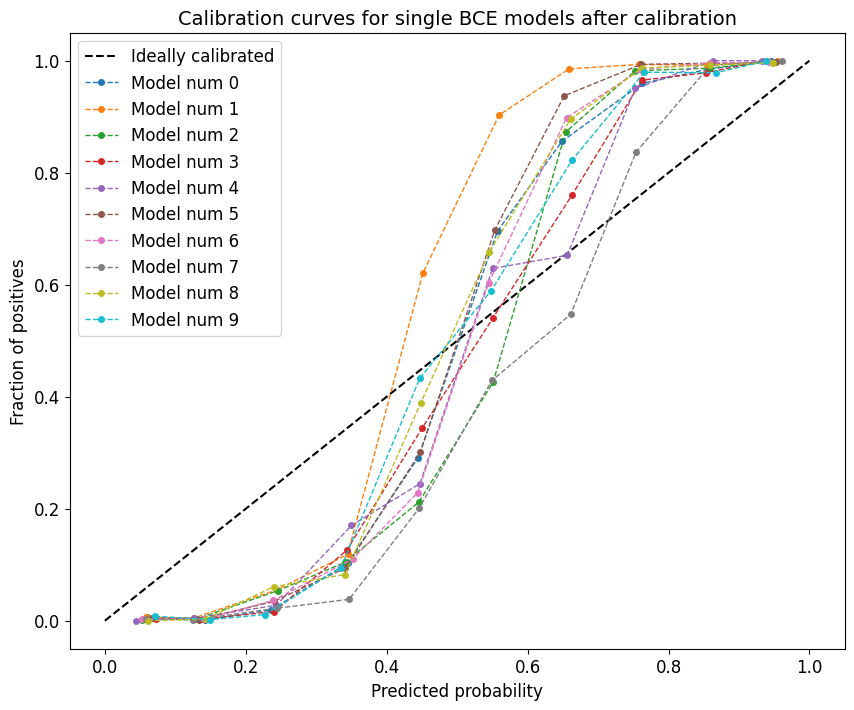

In [6]:
title = "Calibration curves for single BCE models after calibration"

calibrate_all_models_in_ensemble(ens_bce, test_dataloader, verbose=False)
plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title)

### Metrics for calibrated ensemble

In [8]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cpu",
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4],
)

  5%|▍         | 1/21 [00:00<00:02,  8.84it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 16.84it/s]


TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 

In [11]:
# wasserstein
threshold_list = np.linspace(0, 1, 50)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    device="cpu",
    verbose=True,
    window_size_list=[1, 2, 3],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

 10%|▉         | 2/21 [00:00<00:01, 16.54it/s]

Collectting model's outputs


  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.36734693877551017
AUDC: 0.0, Time to FA: 11.3725, DD: 1.2214, F1: 0.9687, Cover: 0.9112, Max Cover: 0.9112
Max F1 with margin 1: 0.9487
Max F1 with margin 2: 0.9627
Max F1 with margin 4: 0.9659
window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.26530612244897955
AUDC: 0.0, Time to FA: 11.4435, DD: 1.2259, F1: 0.9722, Cover: 0.9186, Max Cover: 0.9186
Max F1 with margin 1: 0.9709
Max F1 with margin 2: 0.9718
Max F1 with margin 4: 0.9718
window_size = 2, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.2857142857142857
AUDC: 0.0, Time to FA: 11.1174, DD: 1.3111, F1: 0.9662, Cover: 0.8944, Max Cover: 0.8944
Max F1 with margin 1: 0.8432
Max F1 with margin 2: 0.9561
Max F1 with margin 4: 0.9607
window_size = 2, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.24489795918367346
AUDC: 0.0, Time to FA: 11.3702, DD: 1.285, F1: 0.9714, Cover: 0.9099, Max Cover: 0.9099
Max F1 with margin 1: 0.9134
Max F1 with margin 2: 0.9691
Max F1 with margin 4: 0.9695
window_size = 3, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.2857142857142857
AUDC: 0.0, Time to FA: 11.3254, DD: 2.0426, F1: 0.959, Cover: 0.8433, Max Cover: 0.8433
Max F1 with margin 1: 0.0853
Max F1 with margin 2: 0.9184
Max F1 with margin 4: 0.9524
window_size = 3, anchor_window_type = prev


100%|██████████| 50/50 [01:55<00:00,  2.31s/it]

Results for best threshold = 0.2040816326530612
AUDC: 0.0, Time to FA: 11.2655, DD: 1.442, F1: 0.9647, Cover: 0.8918, Max Cover: 0.8918
Max F1 with margin 1: 0.7895
Max F1 with margin 2: 0.9451
Max F1 with margin 4: 0.9615


{(1, 'start'): (0.0,
  11.372475624084473,
  1.221391201019287,
  0.9686534216335541,
  0.9112449108913993,
  0.9112449108913993,
  {1: 0.9486948694869487, 2: 0.9626998223801065, 4: 0.9659141212926073}),
 (1, 'prev'): (0.0,
  11.443530082702637,
  1.2258788347244263,
  0.9722344645218158,
  0.9186266715090748,
  0.9186266715090748,
  {1: 0.970873786407767, 2: 0.9717813051146384, 4: 0.9717813051146384}),
 (2, 'start'): (0.0,
  11.117426872253418,
  1.3111443519592285,
  0.966183574879227,
  0.894428278351398,
  0.894428278351398,
  {1: 0.8432432432432433, 2: 0.9560975609756097, 4: 0.9607064017660044}),
 (2, 'prev'): (0.0,
  11.370231628417969,
  1.2849663496017456,
  0.9713530189510797,
  0.9098539105549538,
  0.9098539105549538,
  {1: 0.9134078212290503, 2: 0.9690812720848057, 4: 0.9695364238410596}),
 (3, 'start'): (0.0,
  11.325355529785156,
  2.042632818222046,
  0.9589652096342551,
  0.8433331991669025,
  0.8433331991669025,
  {1: 0.08531583264971287, 2: 0.9184430027803522, 4: 0.95

In [14]:
compute_stds(
    ens_bce,
    test_dataloader=test_dataloader,
    half_windows_list=[1, 2, 3],
    verbose=True,
    device="cpu",
);

  5%|▍         | 1/21 [00:00<00:02,  9.27it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 16.03it/s]


Half-window: 1
CP stds list:
Mean = 0.03981080801143759, number is 1141
Normal stds list:
Mean = 0.02655655362334765, number is 1304
p_val analytical = 8.685884549202846e-30, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------
Half-window: 2
CP stds list:
Mean = 0.037802723253522914, number is 1141
Normal stds list:
Mean = 0.026328707810885005, number is 1268
p_val analytical = 7.003568283072527e-22, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------
Half-window: 3
CP stds list:
Mean = 0.03559003986734946, number is 1141
Normal stds list:
Mean = 0.026202670583087537, number is 1224
p_val analytical = 1.896309390822877e-14, p_val permutational = 9.999000099990002e-05
Stds are not statistically equal
--------------------------------------------------


In [18]:
# cusums

ens_bce.args["cusum"]["normal_sigma"] = 0.0266
ens_bce.args["cusum"]["half_window"] = 0.0398
ens_bce.args["cusum"]["half_window"] = 1

res_cusums = all_cusums_evaluation_pipeline(
    ens_bce,
    threshold_number=300,
    test_dataloader=test_dataloader,
    margin_list=[1, 2, 4],
    device="cpu",
    verbose=True,
    min_th_quant=0.1,
    max_th_quant=0.9,
)

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|▉         | 2/21 [00:00<00:01, 11.78it/s]

Collectting model's outputs


  0%|          | 0/300 [00:00<?, ?it/s]

Evaluating CUSUM model with cusum_mode = old and conditional = True
Threshold range: (0.0, 27.67416000366211)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 8.052347559593992
AUDC: 0.0, Time to FA: 10.3807, DD: 0.3732, F1: 0.9823, Cover: 0.9905, Max Cover: 0.9905
Max F1 with margin 1: 0.9757
Max F1 with margin 2: 0.9775
Max F1 with margin 4: 0.9797
Evaluating CUSUM model with cusum_mode = correct and conditional = False
Threshold range: (0.0, 5449.998046875)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 182.27418216973246
AUDC: 0.0, Time to FA: 11.1032, DD: 0.169, F1: 0.9935, Cover: 0.9895, Max Cover: 0.9895
Max F1 with margin 1: 0.9861
Max F1 with margin 2: 0.9892
Max F1 with margin 4: 0.9913
Evaluating CUSUM model with cusum_mode = correct and conditional = True
Threshold range: (0.0, 12514.330078125)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 11.0269, DD: 0.0957, F1: 0.9909, Cover: 0.9937, Max Cover: 0.9937
Max F1 with margin 1: 0.9861
Max F1 with margin 2: 0.9892
Max F1 with margin 4: 0.9914
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = False
Threshold range: (0.23903945088386536, 5268.896484375)


  0%|          | 0/300 [00:00<?, ?it/s]

Results for best threshold = 158.8273906358907
AUDC: 0.0, Time to FA: 11.0942, DD: 0.1541, F1: 0.9935, Cover: 0.9904, Max Cover: 0.9904
Max F1 with margin 1: 0.9856
Max F1 with margin 2: 0.9887
Max F1 with margin 4: 0.9927
Evaluating CUSUM model with cusum_mode = new_criteria and conditional = True
Threshold range: (0.22904592752456665, 14792.630859375)


100%|██████████| 300/300 [02:06<00:00,  2.38it/s]


Results for best threshold = 99.17487745560132
AUDC: 0.0, Time to FA: 11.0733, DD: 0.4174, F1: 0.9887, Cover: 0.9678, Max Cover: 0.9678
Max F1 with margin 1: 0.9552
Max F1 with margin 2: 0.97
Max F1 with margin 4: 0.9808


{('old',
  True): {0.0: (0.0,
   3.107703924179077,
   0.0359012708067894,
   0.1520387007601935,
   0.6255602327184061,
   0.6255602327184061,
   {1: 0.20174848688634836,
    2: 0.2737249838605552,
    4: 0.41681468324452337}), 0.092555719075793: (0.0,
   3.512341022491455,
   0.03814510256052017,
   0.1846571622539036,
   0.6329141697122928,
   0.6329141697122928,
   {1: 0.23614775725593667,
    2: 0.30759493670886073,
    4: 0.442632498543972}), 0.185111438151586: (0.0,
   3.919222116470337,
   0.03964098542928696,
   0.20833333333333334,
   0.6390128004723475,
   0.6390128004723475,
   {1: 0.2620599739243807,
    2: 0.3358302122347066,
    4: 0.4642857142857143}), 0.277667157227379: (0.0,
   4.282722473144531,
   0.04637247696518898,
   0.23051299133910727,
   0.6488508362736902,
   0.6488508362736902,
   {1: 0.27979274611398963,
    2: 0.3523573200992556,
    4: 0.4909090909090909}), 0.370222876303172: (0.0,
   4.63350772857666,
   0.05086013302206993,
   0.2552910052910053,
   0.

# BCE-SGLD HAR

In [17]:
model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [18]:
path_to_models_folder = "saved_models/bce/human_activity/sgld_adam"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

100%|██████████| 21/21 [00:00<00:00, 27.66it/s]


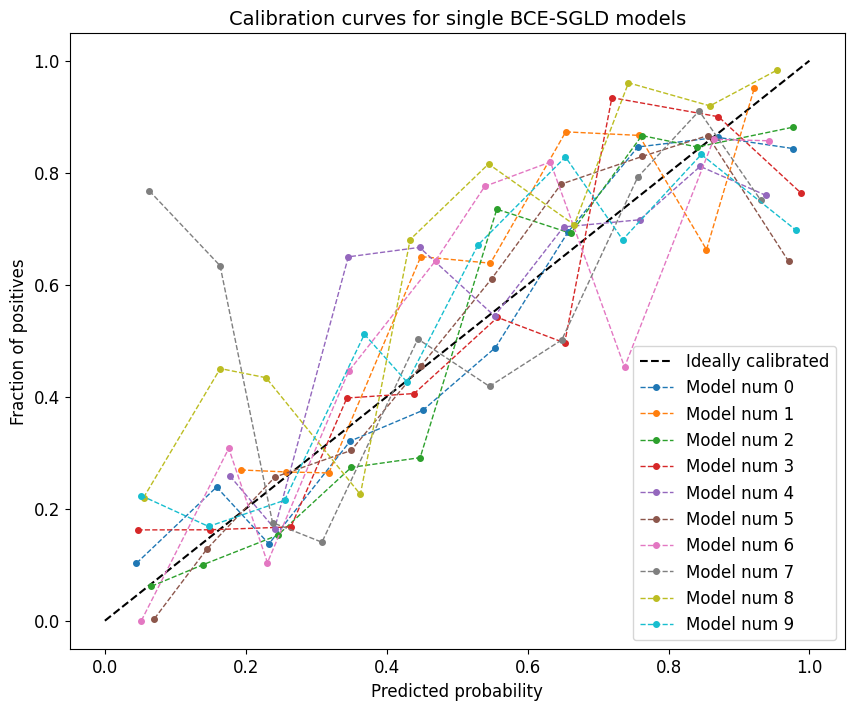

In [19]:
title = "Calibration curves for single BCE-SGLD models"

plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title);

100%|██████████| 21/21 [00:00<00:00, 28.18it/s]


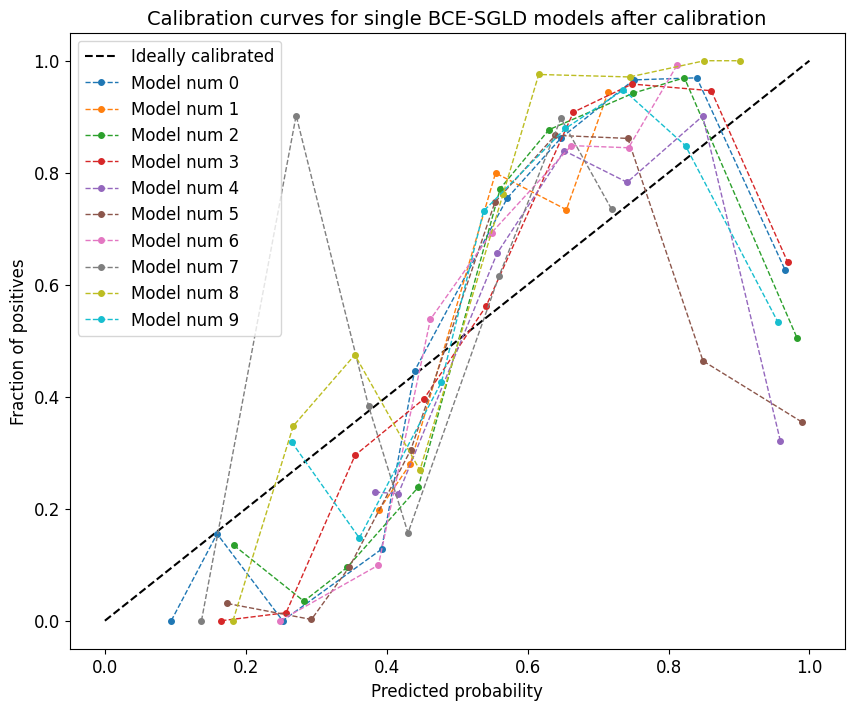

In [20]:
title = "Calibration curves for single BCE-SGLD models after calibration"

calibrate_all_models_in_ensemble(ens_bce, test_dataloader, verbose=False)
plot_calibration_curves(ens_bce.models_list, test_dataloader, title=title)

# BCE Explosion

In [4]:
model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [5]:
path_to_models_folder = "saved_models/bce/explosion/layer_norm/train_anomaly_num_155"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


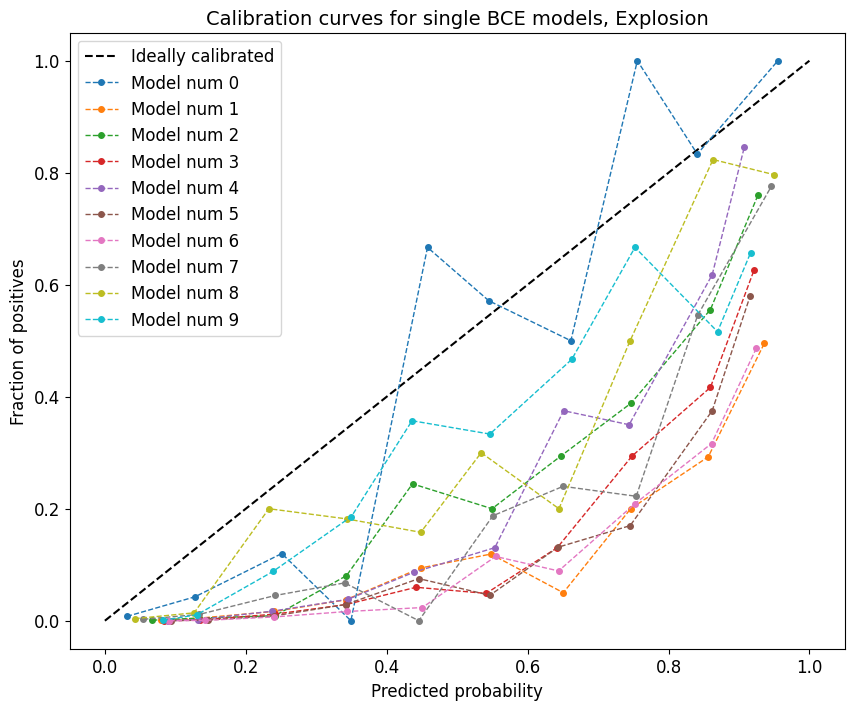

In [24]:
title = "Calibration curves for single BCE models, Explosion"

plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda"
);

In [6]:
preprocessor = ens_bce.models_list[0].extractor

calibrate_all_models_in_ensemble(
    ens_bce, test_dataloader, preprocessor=preprocessor, verbose=True, device="cuda"
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.259, ECE: 0.132
Optimal temperature: 1.484
After temperature - NLL: 0.276, ECE: 0.166


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


Before temperature - NLL: 0.379, ECE: 0.150
Optimal temperature: 1.528
After temperature - NLL: 0.365, ECE: 0.180


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.250, ECE: 0.136
Optimal temperature: 1.475
After temperature - NLL: 0.276, ECE: 0.168


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Before temperature - NLL: 0.319, ECE: 0.146
Optimal temperature: 1.231
After temperature - NLL: 0.320, ECE: 0.162


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.254, ECE: 0.135
Optimal temperature: 1.475
After temperature - NLL: 0.278, ECE: 0.162


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Before temperature - NLL: 0.322, ECE: 0.150


  0%|          | 0/20 [00:00<?, ?it/s]

Optimal temperature: 1.177
After temperature - NLL: 0.324, ECE: 0.162


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.379, ECE: 0.155
Optimal temperature: 1.500
After temperature - NLL: 0.367, ECE: 0.183


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.278, ECE: 0.139
Optimal temperature: 1.485
After temperature - NLL: 0.292, ECE: 0.169


  0%|          | 0/20 [00:00<?, ?it/s]

Before temperature - NLL: 0.238, ECE: 0.129
Optimal temperature: 1.480
After temperature - NLL: 0.260, ECE: 0.161


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]

Before temperature - NLL: 0.246, ECE: 0.134
Optimal temperature: 1.477
After temperature - NLL: 0.270, ECE: 0.166


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


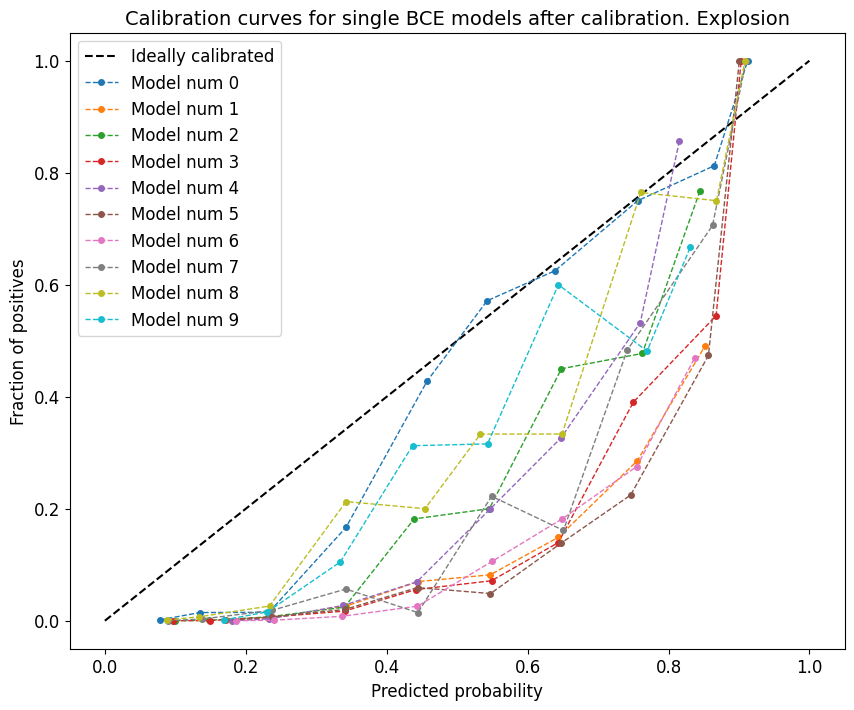

In [7]:
title = "Calibration curves for single BCE models after calibration. Explosion"

plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda", verbose=True
)

# BCE-SGLD Explosion

In [26]:
model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [27]:
path_to_models_folder = "saved_models/bce/explosion/sgld_adam"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


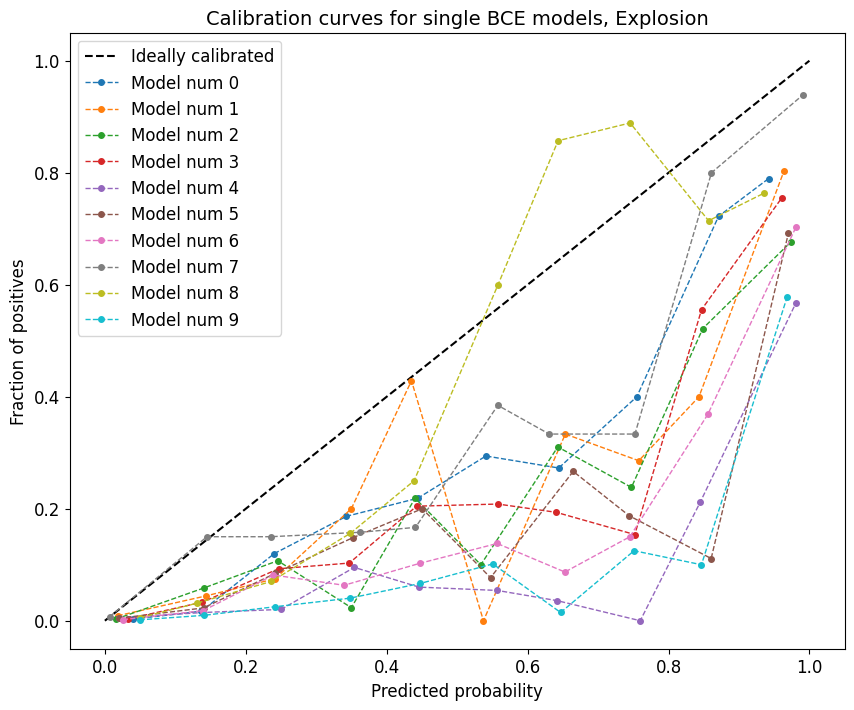

In [28]:
title = "Calibration curves for single BCE models, Explosion"

plot_calibration_curves(
    ens_bce.models_list, test_dataloader, title=title, device="cuda"
);

## Try to calibrate

- Need model to output logits
- Need vedeo feature extraction inside the core model ...

In [8]:
orig_model = ens_bce.models_list[0]
valid_loader = test_dataloader

scaled_model = ModelWithTemperature(orig_model)

scaled_model.set_temperature(valid_loader)

ValueError: Expected target size (315, 1), got torch.Size([315, 16])